# Analysis of cell nuclei morphology

### I - Preprocessing

In this section an example how to generate single nuclei from a segmented and labbeled image is provided.
For this we use a `format_nuclei(..)`, which takes the following variables as input:
- objects : bounding box for each detected and labelled object in the image
- num_object: index of object to be cropped
- segmented_image: segmented image (binary)
- labelled_image: labelled segmented image
- image: original image
- file: filename
- cropsize: size of crop (+/-  average radius of the nuclei (in pixels) + 15% of that length )

In [23]:
#packages
import numpy as np
from skimage import io,img_as_ubyte
from scipy.ndimage import measurements,find_objects,interpolation,label

In [34]:
def format_nuclei(file,image,segmented_image,labelled_image,bb_object,index_object,cropsize):    
            nuc=segmented_image[bb_object[index_object]]
            mask=nuc==0
            crop_1=image[:,:,:,0]
            crop_1=crop_1[bb_object[index_object]]
            crop_1[mask]=0
            crop_1=np.pad(crop_1,((cropsize,cropsize),(cropsize,cropsize),(cropsize,cropsize)),'constant')
            crop_2=image[:,:,:,1]
            crop_2=crop_2[bb_object[index_object]]
            crop_2[mask]=0
            crop_2=np.pad(crop_2,((cropsize,cropsize),(cropsize,cropsize),(cropsize,cropsize)),'constant')
            nuc=np.pad(nuc,((cropsize,cropsize),(cropsize,cropsize),(cropsize,cropsize)),'constant')
            cm=measurements.center_of_mass(nuc)
            cmi=int(cm[0]),int(cm[1]),int(cm[2])
            binary=nuc[(cmi[0]-cropsize):(cmi[0]+cropsize),(cmi[1]-cropsize):(cmi[1]+cropsize),(cmi[2]-cropsize):(cmi[2]+cropsize)] 
            ch_1=crop_1[(cmi[0]-cropsize):(cmi[0]+cropsize),(cmi[1]-cropsize):(cmi[1]+cropsize),(cmi[2]-cropsize):(cmi[2]+cropsize)]  
            ch_2=crop_2[(cmi[0]-cropsize):(cmi[0]+cropsize),(cmi[1]-cropsize):(cmi[1]+cropsize),(cmi[2]-cropsize):(cmi[2]+cropsize)]  
            new_img=np.stack((img_as_ubyte(binary),img_as_ubyte(ch_1),img_as_ubyte(ch_2)))
            filename=file[:-4]+'_'+str(index_object+1)+'.tif'
            io.imsave((filename),new_img)
            return new_img    

The image we load is in the format `image[z,x,y,channels]`, make sure you have the same. If not, you can use [`np.reshape()`](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html). 

In [37]:
#path to the file
file='./crop_sn/10_11_21_WT_C-D_A_1_gb_05.tif'

image = io.imread(file)
#pixel spacing in image, xy pixel = 0.15µm and zy = 0.26µm
spacing = 0.26/0.15
image=interpolation.zoom(image, (spacing,1,1,1),order=1)

#the segmented_image needs no spacing since it has already been processed in a previous step
segmented_image=io.imread('./crop_sn/segmented_image.tif')

#labelled image is created from segmented_image
labelled_image,labels=label(segmented_image>0)

#get the binding box coordinates from the objects in the labelled image
bb_objects=find_objects(labelled_image)

#cropsize, must be interger
cropsize=int(40+0.15*40)
    
nuclei=[format_nuclei(file,image,segmented_image,labelled_image,bb_objects,index_object,cropsize) for index_object in range(0,len(bb_objects))]   

In [38]:
# to continue the workflow, the images with the cropped nuclei need to have the same dimensions
# pls note that the cropped nuclei have the format image[channels,z,x,y].
dimensions=[print(nuc.shape) for nuc in nuclei]

(3, 92, 92, 92)
(3, 92, 92, 92)
(3, 92, 92, 92)
(3, 92, 92, 92)
(3, 92, 92, 92)
(3, 92, 92, 92)
(3, 92, 92, 92)
(3, 92, 92, 92)
(3, 92, 92, 92)


### II - Spherical transformation and Fourier transform

This part of the workflow transforms an n x n x n image to spherical coordinates before Fourier transform is applied. In brief, spherical transformation renders rotation invariance and Fouriertransformation followed by [`.flatten()`](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.flatten.html) transforms the image into a n*n*n long vector. For technical details refer to [Wagner et al., 2019](https://ieeexplore.ieee.org/document/8856734).

The following functions were coded with the help of Patrick Wagner the author of [Wagner et al., 2019](https://ieeexplore.ieee.org/document/8856734) (commented in code)

The function `GFT(..)` uses the following variables:
- file: filename of the input image
- channel: the channel of interest to pass to the function (max three channels). If 'NONE', than the array is assumed to be in image[z,x,y]
- size: An input image with dimension 40x40x40 yields a vector of length 64000 and is already sufficient as a morphological feature vector. One could try out lower resolution below 35 and compare the results. The smaller the image the, faster the function 


In [45]:
#packages
import numpy as np
import os
import glob
from scipy import fftpack
from scipy.ndimage.interpolation import geometric_transform
from skimage import io
from skimage.transform import resize

In [43]:
#It is recommended to use size in a range of 40-50. 
#Eg. an input image with dimension 40x40x40 yields a vector of length 64000, this is already sufficient for morphological feature vector
#one could try out lower resolution below 35 and compare the results.

def open_file(file,channel,size):
    #if the input consists of one channel only
    if channel == 'NONE':
        img=io.imread(file)
        downscale=size/img.shape[1]
        img=resize(img, (img.shape[1]*downscale,img.shape[2]*downscale,img.shape[3]*downscale), anti_aliasing=False)
    #if the input has more than one channel
    else:
        img=io.imread(file)
        downscale=size/img.shape[1]
        img=resize(img, (3,img.shape[1]*downscale,img.shape[2]*downscale,img.shape[3]*downscale),anti_aliasing=False)
        img=img[channel,:,:,:] 
    return img
                
def img_shape(file,channel,size):
    if channel == 'NONE':
        shape_img=open_file(file,channel,size).shape
    else:
        shape_img=open_file(file,channel,size).shape
    return shape_img

#transformation to spherical coordinates
#code snippet kindly provided by Patrick Wagner
def to_spherical(img, shape, order=1):
                    D = shape[1] - 1
                    R = D/2.
                    def transform(coords):
                        [z,x,y] =  coords
                        phi = np.pi*z / R
                        theta = np.pi*y / R
                        rho =  x / 2.

                        x = rho*np.sin(theta)*np.cos(phi) + R
                        y = rho*np.sin(theta)*np.sin(phi) + R
                        z = rho*np.cos(theta) + R
                        return z,x,y

                    spherical = geometric_transform(img, transform, order=order, mode='nearest', prefilter=False)
                    return spherical

#generic Fourier transformation
#code snippet kindly provided by Patrick Wagner
def GFT(file,channel,size):
    print(file)
    result=abs(fftpack.fftshift(fftpack.fftn(to_spherical(open_file(file,channel,size),img_shape(file,channel,size))))).flatten()
    return result


<a id='II'></a>

In [46]:
path='./Data/'

#this code creates a list with all the files to be passed to GFT(). Make sure that they all contain the same dimensions
file_location = os.path.join(path,'*.tif')
filenames = glob.glob(file_location)
filenames.sort()


#ch 0: Segementation 
ch_0 = 0
#ch 1: Protein 1
ch_1 = 1
#ch 2: Protein 2
ch_2 = 2

size = 35
gft=np.concatenate(([np.array([GFT(file,ch_0,size) for file in filenames])],
                    [np.array([GFT(file,ch_1,size) for file in filenames])],
                    [np.array([GFT(file,ch_2,size) for file in filenames])]),axis=0) 

./Data/10_11_22_WT_C-D_A+B_01-01.tif
./Data/10_11_22_WT_C-D_A+B_01-02.tif
./Data/10_11_22_WT_C-D_A+B_01-03.tif
./Data/10_11_22_WT_C-D_A+B_01-04.tif
./Data/10_11_22_WT_C-D_A+B_01-05.tif
./Data/10_11_22_WT_C-D_A+B_01-06.tif
./Data/10_11_22_WT_C-D_A+B_01-07.tif
./Data/10_11_22_WT_C-D_A+B_01-08.tif
./Data/10_11_22_WT_C-D_A+B_01-09.tif
./Data/10_11_22_WT_C-D_A+B_01-10.tif
./Data/10_11_22_WT_C-D_A+B_01-12.tif
./Data/10_11_22_WT_C-D_A+B_01-13.tif
./Data/10_11_22_WT_C-D_A+B_01-14.tif
./Data/10_11_22_WT_C-D_A+B_02-01.tif
./Data/10_11_22_WT_C-D_A+B_02-02.tif
./Data/10_11_22_WT_C-D_A+B_02-03.tif
./Data/10_11_22_WT_C-D_A+B_02-04.tif
./Data/10_11_22_WT_C-D_A+B_02-05.tif
./Data/10_11_22_WT_C-D_A+B_02-06.tif
./Data/10_11_22_WT_C-D_A+B_02-07.tif
./Data/10_11_22_WT_C-D_A+B_02-08.tif
./Data/10_11_22_WT_C-D_A+B_02-09.tif
./Data/10_11_22_WT_C-D_A+B_02-10.tif
./Data/10_11_22_WT_C-D_A+B_02-11.tif
./Data/10_11_22_WT_C-D_A+B_02-12.tif
./Data/10_11_22_WT_C-D_A+B_02-13.tif
./Data/10_11_22_WT_C-D_A+B_02-14.tif
.

./Data/10_11_22_WT_C-D_A+B_13-10.tif
./Data/10_11_22_WT_C-D_A+B_13-11.tif
./Data/10_11_22_WT_C-D_A+B_13-12.tif
./Data/10_11_22_WT_C-D_A+B_13-13.tif
./Data/10_11_22_WT_C-D_A+B_13-14.tif
./Data/10_11_22_WT_C-D_A+B_13-15.tif
./Data/10_11_22_WT_C-D_A+B_13-16.tif
./Data/10_11_22_WT_C-D_A+B_13-17.tif
./Data/10_11_22_WT_C-D_A+B_14-01.tif
./Data/10_11_22_WT_C-D_A+B_14-02.tif
./Data/10_11_22_WT_C-D_A+B_14-03.tif
./Data/10_11_22_WT_C-D_A+B_14-04.tif
./Data/10_11_22_WT_C-D_A+B_14-05.tif
./Data/10_11_22_WT_C-D_A+B_14-06.tif
./Data/10_11_22_WT_C-D_A+B_14-07.tif
./Data/10_11_22_WT_C-D_A+B_14-08.tif
./Data/10_11_22_WT_C-D_A+B_14-09.tif
./Data/10_11_22_WT_C-D_A+B_14-10.tif
./Data/10_11_22_WT_C-D_A+B_14-11.tif
./Data/10_11_22_WT_C-D_A+B_14-12.tif
./Data/10_11_22_WT_C-D_A+B_14-13.tif
./Data/10_11_22_WT_C-D_A+B_14-14.tif
./Data/10_11_22_WT_C-D_A+B_14-15.tif
./Data/10_11_22_WT_C-D_A+B_14-16.tif
./Data/10_11_22_WT_C-D_A+B_15-01.tif
./Data/10_11_22_WT_C-D_A+B_15-02.tif
./Data/10_11_22_WT_C-D_A+B_15-03.tif
.

./Data/10_11_22_WT_C-D_A_09-07.tif
./Data/10_11_22_WT_C-D_A_09-08.tif
./Data/10_11_22_WT_C-D_A_09-09.tif
./Data/10_11_22_WT_C-D_A_09-10.tif
./Data/10_11_22_WT_C-D_A_09-11.tif
./Data/10_11_22_WT_C-D_A_09-12.tif
./Data/10_11_22_WT_C-D_A_09-13.tif
./Data/10_11_22_WT_C-D_A_09-14.tif
./Data/10_11_22_WT_C-D_A_10-01.tif
./Data/10_11_22_WT_C-D_A_10-02.tif
./Data/10_11_22_WT_C-D_A_10-03.tif
./Data/10_11_22_WT_C-D_A_10-04.tif
./Data/10_11_22_WT_C-D_A_10-05.tif
./Data/10_11_22_WT_C-D_A_10-06.tif
./Data/10_11_22_WT_C-D_A_10-07.tif
./Data/10_11_22_WT_C-D_A_10-08.tif
./Data/10_11_22_WT_C-D_A_10-09.tif
./Data/10_11_22_WT_C-D_A_10-10.tif
./Data/10_11_22_WT_C-D_A_11-01.tif
./Data/10_11_22_WT_C-D_A_11-02.tif
./Data/10_11_22_WT_C-D_A_11-03.tif
./Data/10_11_22_WT_C-D_A_11-04.tif
./Data/10_11_22_WT_C-D_A_11-05.tif
./Data/10_11_22_WT_C-D_A_11-06.tif
./Data/10_11_22_WT_C-D_A_11-07.tif
./Data/10_11_22_WT_C-D_A_11-08.tif
./Data/10_11_22_WT_C-D_A_11-09.tif
./Data/10_11_22_WT_C-D_A_11-10.tif
./Data/10_11_22_WT_C

./Data/10_11_22_WT_C-D_A_29-09.tif
./Data/10_11_22_WT_C-D_A_29-10.tif
./Data/10_11_22_WT_C-D_A_29-11.tif
./Data/10_11_22_WT_C-D_A_29-12.tif
./Data/10_11_22_WT_C-D_A+B_01-01.tif
./Data/10_11_22_WT_C-D_A+B_01-02.tif
./Data/10_11_22_WT_C-D_A+B_01-03.tif
./Data/10_11_22_WT_C-D_A+B_01-04.tif
./Data/10_11_22_WT_C-D_A+B_01-05.tif
./Data/10_11_22_WT_C-D_A+B_01-06.tif
./Data/10_11_22_WT_C-D_A+B_01-07.tif
./Data/10_11_22_WT_C-D_A+B_01-08.tif
./Data/10_11_22_WT_C-D_A+B_01-09.tif
./Data/10_11_22_WT_C-D_A+B_01-10.tif
./Data/10_11_22_WT_C-D_A+B_01-12.tif
./Data/10_11_22_WT_C-D_A+B_01-13.tif
./Data/10_11_22_WT_C-D_A+B_01-14.tif
./Data/10_11_22_WT_C-D_A+B_02-01.tif
./Data/10_11_22_WT_C-D_A+B_02-02.tif
./Data/10_11_22_WT_C-D_A+B_02-03.tif
./Data/10_11_22_WT_C-D_A+B_02-04.tif
./Data/10_11_22_WT_C-D_A+B_02-05.tif
./Data/10_11_22_WT_C-D_A+B_02-06.tif
./Data/10_11_22_WT_C-D_A+B_02-07.tif
./Data/10_11_22_WT_C-D_A+B_02-08.tif
./Data/10_11_22_WT_C-D_A+B_02-09.tif
./Data/10_11_22_WT_C-D_A+B_02-10.tif
./Data/10

./Data/10_11_22_WT_C-D_A+B_13-06.tif
./Data/10_11_22_WT_C-D_A+B_13-07.tif
./Data/10_11_22_WT_C-D_A+B_13-08.tif
./Data/10_11_22_WT_C-D_A+B_13-09.tif
./Data/10_11_22_WT_C-D_A+B_13-10.tif
./Data/10_11_22_WT_C-D_A+B_13-11.tif
./Data/10_11_22_WT_C-D_A+B_13-12.tif
./Data/10_11_22_WT_C-D_A+B_13-13.tif
./Data/10_11_22_WT_C-D_A+B_13-14.tif
./Data/10_11_22_WT_C-D_A+B_13-15.tif
./Data/10_11_22_WT_C-D_A+B_13-16.tif
./Data/10_11_22_WT_C-D_A+B_13-17.tif
./Data/10_11_22_WT_C-D_A+B_14-01.tif
./Data/10_11_22_WT_C-D_A+B_14-02.tif
./Data/10_11_22_WT_C-D_A+B_14-03.tif
./Data/10_11_22_WT_C-D_A+B_14-04.tif
./Data/10_11_22_WT_C-D_A+B_14-05.tif
./Data/10_11_22_WT_C-D_A+B_14-06.tif
./Data/10_11_22_WT_C-D_A+B_14-07.tif
./Data/10_11_22_WT_C-D_A+B_14-08.tif
./Data/10_11_22_WT_C-D_A+B_14-09.tif
./Data/10_11_22_WT_C-D_A+B_14-10.tif
./Data/10_11_22_WT_C-D_A+B_14-11.tif
./Data/10_11_22_WT_C-D_A+B_14-12.tif
./Data/10_11_22_WT_C-D_A+B_14-13.tif
./Data/10_11_22_WT_C-D_A+B_14-14.tif
./Data/10_11_22_WT_C-D_A+B_14-15.tif
.

./Data/10_11_22_WT_C-D_A_09-03.tif
./Data/10_11_22_WT_C-D_A_09-04.tif
./Data/10_11_22_WT_C-D_A_09-05.tif
./Data/10_11_22_WT_C-D_A_09-06.tif
./Data/10_11_22_WT_C-D_A_09-07.tif
./Data/10_11_22_WT_C-D_A_09-08.tif
./Data/10_11_22_WT_C-D_A_09-09.tif
./Data/10_11_22_WT_C-D_A_09-10.tif
./Data/10_11_22_WT_C-D_A_09-11.tif
./Data/10_11_22_WT_C-D_A_09-12.tif
./Data/10_11_22_WT_C-D_A_09-13.tif
./Data/10_11_22_WT_C-D_A_09-14.tif
./Data/10_11_22_WT_C-D_A_10-01.tif
./Data/10_11_22_WT_C-D_A_10-02.tif
./Data/10_11_22_WT_C-D_A_10-03.tif
./Data/10_11_22_WT_C-D_A_10-04.tif
./Data/10_11_22_WT_C-D_A_10-05.tif
./Data/10_11_22_WT_C-D_A_10-06.tif
./Data/10_11_22_WT_C-D_A_10-07.tif
./Data/10_11_22_WT_C-D_A_10-08.tif
./Data/10_11_22_WT_C-D_A_10-09.tif
./Data/10_11_22_WT_C-D_A_10-10.tif
./Data/10_11_22_WT_C-D_A_11-01.tif
./Data/10_11_22_WT_C-D_A_11-02.tif
./Data/10_11_22_WT_C-D_A_11-03.tif
./Data/10_11_22_WT_C-D_A_11-04.tif
./Data/10_11_22_WT_C-D_A_11-05.tif
./Data/10_11_22_WT_C-D_A_11-06.tif
./Data/10_11_22_WT_C

./Data/10_11_22_WT_C-D_A_29-05.tif
./Data/10_11_22_WT_C-D_A_29-06.tif
./Data/10_11_22_WT_C-D_A_29-07.tif
./Data/10_11_22_WT_C-D_A_29-08.tif
./Data/10_11_22_WT_C-D_A_29-09.tif
./Data/10_11_22_WT_C-D_A_29-10.tif
./Data/10_11_22_WT_C-D_A_29-11.tif
./Data/10_11_22_WT_C-D_A_29-12.tif
./Data/10_11_22_WT_C-D_A+B_01-01.tif
./Data/10_11_22_WT_C-D_A+B_01-02.tif
./Data/10_11_22_WT_C-D_A+B_01-03.tif
./Data/10_11_22_WT_C-D_A+B_01-04.tif
./Data/10_11_22_WT_C-D_A+B_01-05.tif
./Data/10_11_22_WT_C-D_A+B_01-06.tif
./Data/10_11_22_WT_C-D_A+B_01-07.tif
./Data/10_11_22_WT_C-D_A+B_01-08.tif
./Data/10_11_22_WT_C-D_A+B_01-09.tif
./Data/10_11_22_WT_C-D_A+B_01-10.tif
./Data/10_11_22_WT_C-D_A+B_01-12.tif
./Data/10_11_22_WT_C-D_A+B_01-13.tif
./Data/10_11_22_WT_C-D_A+B_01-14.tif
./Data/10_11_22_WT_C-D_A+B_02-01.tif
./Data/10_11_22_WT_C-D_A+B_02-02.tif
./Data/10_11_22_WT_C-D_A+B_02-03.tif
./Data/10_11_22_WT_C-D_A+B_02-04.tif
./Data/10_11_22_WT_C-D_A+B_02-05.tif
./Data/10_11_22_WT_C-D_A+B_02-06.tif
./Data/10_11_22_W

./Data/10_11_22_WT_C-D_A+B_13-02.tif
./Data/10_11_22_WT_C-D_A+B_13-03.tif
./Data/10_11_22_WT_C-D_A+B_13-04.tif
./Data/10_11_22_WT_C-D_A+B_13-05.tif
./Data/10_11_22_WT_C-D_A+B_13-06.tif
./Data/10_11_22_WT_C-D_A+B_13-07.tif
./Data/10_11_22_WT_C-D_A+B_13-08.tif
./Data/10_11_22_WT_C-D_A+B_13-09.tif
./Data/10_11_22_WT_C-D_A+B_13-10.tif
./Data/10_11_22_WT_C-D_A+B_13-11.tif
./Data/10_11_22_WT_C-D_A+B_13-12.tif
./Data/10_11_22_WT_C-D_A+B_13-13.tif
./Data/10_11_22_WT_C-D_A+B_13-14.tif
./Data/10_11_22_WT_C-D_A+B_13-15.tif
./Data/10_11_22_WT_C-D_A+B_13-16.tif
./Data/10_11_22_WT_C-D_A+B_13-17.tif
./Data/10_11_22_WT_C-D_A+B_14-01.tif
./Data/10_11_22_WT_C-D_A+B_14-02.tif
./Data/10_11_22_WT_C-D_A+B_14-03.tif
./Data/10_11_22_WT_C-D_A+B_14-04.tif
./Data/10_11_22_WT_C-D_A+B_14-05.tif
./Data/10_11_22_WT_C-D_A+B_14-06.tif
./Data/10_11_22_WT_C-D_A+B_14-07.tif
./Data/10_11_22_WT_C-D_A+B_14-08.tif
./Data/10_11_22_WT_C-D_A+B_14-09.tif
./Data/10_11_22_WT_C-D_A+B_14-10.tif
./Data/10_11_22_WT_C-D_A+B_14-11.tif
.

./Data/10_11_22_WT_C-D_A_08-08.tif
./Data/10_11_22_WT_C-D_A_08-09.tif
./Data/10_11_22_WT_C-D_A_09-01.tif
./Data/10_11_22_WT_C-D_A_09-02.tif
./Data/10_11_22_WT_C-D_A_09-03.tif
./Data/10_11_22_WT_C-D_A_09-04.tif
./Data/10_11_22_WT_C-D_A_09-05.tif
./Data/10_11_22_WT_C-D_A_09-06.tif
./Data/10_11_22_WT_C-D_A_09-07.tif
./Data/10_11_22_WT_C-D_A_09-08.tif
./Data/10_11_22_WT_C-D_A_09-09.tif
./Data/10_11_22_WT_C-D_A_09-10.tif
./Data/10_11_22_WT_C-D_A_09-11.tif
./Data/10_11_22_WT_C-D_A_09-12.tif
./Data/10_11_22_WT_C-D_A_09-13.tif
./Data/10_11_22_WT_C-D_A_09-14.tif
./Data/10_11_22_WT_C-D_A_10-01.tif
./Data/10_11_22_WT_C-D_A_10-02.tif
./Data/10_11_22_WT_C-D_A_10-03.tif
./Data/10_11_22_WT_C-D_A_10-04.tif
./Data/10_11_22_WT_C-D_A_10-05.tif
./Data/10_11_22_WT_C-D_A_10-06.tif
./Data/10_11_22_WT_C-D_A_10-07.tif
./Data/10_11_22_WT_C-D_A_10-08.tif
./Data/10_11_22_WT_C-D_A_10-09.tif
./Data/10_11_22_WT_C-D_A_10-10.tif
./Data/10_11_22_WT_C-D_A_11-01.tif
./Data/10_11_22_WT_C-D_A_11-02.tif
./Data/10_11_22_WT_C

./Data/10_11_22_WT_C-D_A_29-01.tif
./Data/10_11_22_WT_C-D_A_29-02.tif
./Data/10_11_22_WT_C-D_A_29-03.tif
./Data/10_11_22_WT_C-D_A_29-04.tif
./Data/10_11_22_WT_C-D_A_29-05.tif
./Data/10_11_22_WT_C-D_A_29-06.tif
./Data/10_11_22_WT_C-D_A_29-07.tif
./Data/10_11_22_WT_C-D_A_29-08.tif
./Data/10_11_22_WT_C-D_A_29-09.tif
./Data/10_11_22_WT_C-D_A_29-10.tif
./Data/10_11_22_WT_C-D_A_29-11.tif
./Data/10_11_22_WT_C-D_A_29-12.tif


### III - Construct data frame with experimental details and additional measurements

This part constructs the dataframe with the experimental details. What kind of details are provided is up to the user. The following function `data(...)` uses underscore `'_'` to extract exp. details:
Eg.:

`file = '10_11_22_WT_C_D_A+B_07-05.tif'`

the barcode above can be decoded as follows:

| day | month | year | Genotype | Antibody 1 | Antibody 2 | Treatment | nucleus_id |
| --- | ----- | ---- | -------- | ---------- | ---------- | --------- | ---------- |
| 10  |  11   |  22  |    WT    |      C     |     D      |    A+B    |    07-05   |

note that the nucleus_id provides information in what image the nucleus can be found -> 10_11_22_WT_C_D_A+B_07.tif

####Additional measurements

`data(..)` additionally measures some propieties of the nucleus such as area, volume, solidity etc. this can be costumized and adapted to individual needs


In [77]:
#packages
import numpy as np
import os
import glob
import pandas as pd
from skimage import io
from skimage.measure import regionprops,regionprops_table,marching_cubes_lewiner,mesh_surface_area
from scipy.ndimage import label

In [101]:
def data(file,details,pixelsize,path):
                print(file)
                image=io.imread(file)
                # 2 channels with protein intensity
                if image.shape[0] == 3:
                    #physical measurements
                    img=image[0,:,:,:]
                    
                    #retrieve proprieties with skimage regionprops()
                    proprieties=regionprops(img)
                    area=marching_cubes_lewiner(img,step_size=1)
                    area=mesh_surface_area(area[0],area[1])
                    area=area*pixelsize**2
                    volume=np.count_nonzero(img)
                    volume=volume*pixelsize*pixelsize*pixelsize
                    extent=proprieties[0].extent
                    solidity=proprieties[0].solidity
                    #intensity ch_1 and ch_2
                    protein_2=image[2,:,:,:][img>0].mean()
                    protein_1=image[1,:,:,:][img>0].mean()
                    #data propr.
                    data=[area,volume,extent,solidity,protein_1,protein_2]
                    columns_data=['area [µm$^2$]','volume[µm$^3$]','extent',
                                  'solidity','mean intensity Protein C',
                                  'mean intensity Protein D']
                    #details
                    barcode=file[len(path):-4]
                    barcode=barcode.replace('__','_')
                    #barcode=barcode.replace('-','_')
                    barcode=barcode.split('_')
                    
                    #final data_frame
                    data_final=barcode+data
                    columns=details+columns_data
                    data_frame=pd.DataFrame([data_final],columns=columns)
                # 1 channel with protein intensity   
                elif image.shape[0] == 2:
                    #physical measurements
                    img=image[0,:,:,:]
                    label = label(img>0)
                    #retrieve proprieties with skimage regionprops()
                    proprieties=measure.regionprops(img)
                    area=marching_cubes_lewiner(img,step_size=1)
                    area=mesh_surface_area(area[0],area[1])
                    area=area*pixelsize**2
                    volume=np.count_nonzero(img)
                    volume_µm3=volume*pixelsize*pixelsize*pixelsize
                    extent=proprieties[0].extent
                    solidity=proprieties[0].solidity
                    protein_1=image[1,:,:,:][img>0].mean()
                    #data propr.
                    data=[area,volume,extent,solidity,protein_1]
                    columns_data=['area [µm$^2$]','volume[µm$^3$]','extent',
                                  'solidity','mean intensity Protein C']
                    #details
                    barcode=file[len(path):-4]
                    barcode=barcode.replace('__','_')
                    barcode=barcode.split('_')
                    
                    #final data_frame
                    data_final=barcode+data
                    columns=details+columns_data
                    data_frame=pd.DataFrame([data_final],columns=columns)
                # only 3D image -> img[z,x,y]   
                elif image.shape[0] == 1:
                    #physical measurements
                    #physical measurements
                    img=image[0,:,:,:]
                    label = label(img>0)
                    #retrieve proprieties with skimage regionprops()
                    proprieties=measure.regionprops(img)
                    area=marching_cubes_lewiner(img,step_size=1)
                    area=mesh_surface_area(area[0],area[1])
                    area=area*pixelsize**2
                    volume=np.count_nonzero(img)
                    volume_µm3=volume*pixelsize**3
                    extent=proprieties[0].extent
                    solidity=proprieties[0].solidity
                    #data propr.
                    data=[area,volume,extent,solidity,protein_1]
                    columns_data=['area [µm$^2$]','volume[µm$^3$]','extent',
                                  'solidity']
                    #details
                    barcode=file[len(path):-4]
                    barcode=barcode.replace('__','_')
                    barcode=barcode.split('_')
                    
                    #final data_frame
                    data_final=barcode+data
                    columns=details+columns_data
                    data_frame=pd.DataFrame([data_final],columns=columns)
        
                print (file)
                return data_frame 
                


<a id='data_frame_details'></a>

In [102]:
#what the barcode is encoding for
details = ['Day','Month','Year','Genotype','Protein C','Protein D','Treatment','nucleus_id']

path='./Data/'

#this code creates a list with all the files to be passed to GFT(). Make sure that they all contain the same dimensions
file_location = os.path.join(path,'*.tif')
filenames = glob.glob(file_location)
filenames.sort()

pixelsize_µm=0.396
list_details=[data(file,details,pixelsize_µm,path) for file in filenames]
data_frame_details=pd.concat(table_details).reset_index()
data_frame_details.drop(['index'],axis=1,inplace=True)




./Data/15_3_90_WT_C_D_A+B_01-01.tif


<ipython-input-101-17b3fca2a82f>:11: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  area=marching_cubes_lewiner(img,step_size=1)


./Data/15_3_90_WT_C_D_A+B_01-01.tif
./Data/15_3_90_WT_C_D_A+B_01-02.tif
./Data/15_3_90_WT_C_D_A+B_01-02.tif
./Data/15_3_90_WT_C_D_A+B_01-03.tif
./Data/15_3_90_WT_C_D_A+B_01-03.tif
./Data/15_3_90_WT_C_D_A+B_01-04.tif
./Data/15_3_90_WT_C_D_A+B_01-04.tif
./Data/15_3_90_WT_C_D_A+B_01-05.tif
./Data/15_3_90_WT_C_D_A+B_01-05.tif
./Data/15_3_90_WT_C_D_A+B_01-06.tif
./Data/15_3_90_WT_C_D_A+B_01-06.tif
./Data/15_3_90_WT_C_D_A+B_01-07.tif
./Data/15_3_90_WT_C_D_A+B_01-07.tif
./Data/15_3_90_WT_C_D_A+B_01-08.tif
./Data/15_3_90_WT_C_D_A+B_01-08.tif
./Data/15_3_90_WT_C_D_A+B_01-09.tif
./Data/15_3_90_WT_C_D_A+B_01-09.tif
./Data/15_3_90_WT_C_D_A+B_01-10.tif
./Data/15_3_90_WT_C_D_A+B_01-10.tif
./Data/15_3_90_WT_C_D_A+B_01-12.tif
./Data/15_3_90_WT_C_D_A+B_01-12.tif
./Data/15_3_90_WT_C_D_A+B_01-13.tif
./Data/15_3_90_WT_C_D_A+B_01-13.tif
./Data/15_3_90_WT_C_D_A+B_01-14.tif
./Data/15_3_90_WT_C_D_A+B_01-14.tif
./Data/15_3_90_WT_C_D_A+B_02-01.tif
./Data/15_3_90_WT_C_D_A+B_02-01.tif
./Data/15_3_90_WT_C_D_A+B_02

./Data/15_3_90_WT_C_D_A+B_07-06.tif
./Data/15_3_90_WT_C_D_A+B_07-07.tif
./Data/15_3_90_WT_C_D_A+B_07-07.tif
./Data/15_3_90_WT_C_D_A+B_07-08.tif
./Data/15_3_90_WT_C_D_A+B_07-08.tif
./Data/15_3_90_WT_C_D_A+B_07-09.tif
./Data/15_3_90_WT_C_D_A+B_07-09.tif
./Data/15_3_90_WT_C_D_A+B_07-10.tif
./Data/15_3_90_WT_C_D_A+B_07-10.tif
./Data/15_3_90_WT_C_D_A+B_07-11.tif
./Data/15_3_90_WT_C_D_A+B_07-11.tif
./Data/15_3_90_WT_C_D_A+B_07-12.tif
./Data/15_3_90_WT_C_D_A+B_07-12.tif
./Data/15_3_90_WT_C_D_A+B_07-13.tif
./Data/15_3_90_WT_C_D_A+B_07-13.tif
./Data/15_3_90_WT_C_D_A+B_07-14.tif
./Data/15_3_90_WT_C_D_A+B_07-14.tif
./Data/15_3_90_WT_C_D_A+B_07-15.tif
./Data/15_3_90_WT_C_D_A+B_07-15.tif
./Data/15_3_90_WT_C_D_A+B_07-16.tif
./Data/15_3_90_WT_C_D_A+B_07-16.tif
./Data/15_3_90_WT_C_D_A+B_07-17.tif
./Data/15_3_90_WT_C_D_A+B_07-17.tif
./Data/15_3_90_WT_C_D_A+B_07-18.tif
./Data/15_3_90_WT_C_D_A+B_07-18.tif
./Data/15_3_90_WT_C_D_A+B_08-01.tif
./Data/15_3_90_WT_C_D_A+B_08-01.tif
./Data/15_3_90_WT_C_D_A+B_08

./Data/15_3_90_WT_C_D_A+B_13-16.tif
./Data/15_3_90_WT_C_D_A+B_13-17.tif
./Data/15_3_90_WT_C_D_A+B_13-17.tif
./Data/15_3_90_WT_C_D_A+B_14-01.tif
./Data/15_3_90_WT_C_D_A+B_14-01.tif
./Data/15_3_90_WT_C_D_A+B_14-02.tif
./Data/15_3_90_WT_C_D_A+B_14-02.tif
./Data/15_3_90_WT_C_D_A+B_14-03.tif
./Data/15_3_90_WT_C_D_A+B_14-03.tif
./Data/15_3_90_WT_C_D_A+B_14-04.tif
./Data/15_3_90_WT_C_D_A+B_14-04.tif
./Data/15_3_90_WT_C_D_A+B_14-05.tif
./Data/15_3_90_WT_C_D_A+B_14-05.tif
./Data/15_3_90_WT_C_D_A+B_14-06.tif
./Data/15_3_90_WT_C_D_A+B_14-06.tif
./Data/15_3_90_WT_C_D_A+B_14-07.tif
./Data/15_3_90_WT_C_D_A+B_14-07.tif
./Data/15_3_90_WT_C_D_A+B_14-08.tif
./Data/15_3_90_WT_C_D_A+B_14-08.tif
./Data/15_3_90_WT_C_D_A+B_14-09.tif
./Data/15_3_90_WT_C_D_A+B_14-09.tif
./Data/15_3_90_WT_C_D_A+B_14-10.tif
./Data/15_3_90_WT_C_D_A+B_14-10.tif
./Data/15_3_90_WT_C_D_A+B_14-11.tif
./Data/15_3_90_WT_C_D_A+B_14-11.tif
./Data/15_3_90_WT_C_D_A+B_14-12.tif
./Data/15_3_90_WT_C_D_A+B_14-12.tif
./Data/15_3_90_WT_C_D_A+B_14

./Data/15_3_90_WT_C_D_A+B_22-07.tif
./Data/15_3_90_WT_C_D_A+B_22-08.tif
./Data/15_3_90_WT_C_D_A+B_22-08.tif
./Data/15_3_90_WT_C_D_A+B_22-09.tif
./Data/15_3_90_WT_C_D_A+B_22-09.tif
./Data/15_3_90_WT_C_D_A+B_22-10.tif
./Data/15_3_90_WT_C_D_A+B_22-10.tif
./Data/15_3_90_WT_C_D_A+B_22-11.tif
./Data/15_3_90_WT_C_D_A+B_22-11.tif
./Data/15_3_90_WT_C_D_A+B_22-12.tif
./Data/15_3_90_WT_C_D_A+B_22-12.tif
./Data/15_3_90_WT_C_D_A+B_22-13.tif
./Data/15_3_90_WT_C_D_A+B_22-13.tif
./Data/15_3_90_WT_C_D_A+B_22-14.tif
./Data/15_3_90_WT_C_D_A+B_22-14.tif
./Data/15_3_90_WT_C_D_A+B_22-15.tif
./Data/15_3_90_WT_C_D_A+B_22-15.tif
./Data/15_3_90_WT_C_D_A+B_22-16.tif
./Data/15_3_90_WT_C_D_A+B_22-16.tif
./Data/15_3_90_WT_C_D_A+B_23-01.tif
./Data/15_3_90_WT_C_D_A+B_23-01.tif
./Data/15_3_90_WT_C_D_A+B_23-02.tif
./Data/15_3_90_WT_C_D_A+B_23-02.tif
./Data/15_3_90_WT_C_D_A+B_23-03.tif
./Data/15_3_90_WT_C_D_A+B_23-03.tif
./Data/15_3_90_WT_C_D_A+B_23-04.tif
./Data/15_3_90_WT_C_D_A+B_23-04.tif
./Data/15_3_90_WT_C_D_A+B_23

./Data/15_3_90_WT_C_D_B_10-08.tif
./Data/15_3_90_WT_C_D_B_10-09.tif
./Data/15_3_90_WT_C_D_B_10-09.tif
./Data/15_3_90_WT_C_D_B_10-10.tif
./Data/15_3_90_WT_C_D_B_10-10.tif
./Data/15_3_90_WT_C_D_B_11-01.tif
./Data/15_3_90_WT_C_D_B_11-01.tif
./Data/15_3_90_WT_C_D_B_11-02.tif
./Data/15_3_90_WT_C_D_B_11-02.tif
./Data/15_3_90_WT_C_D_B_11-03.tif
./Data/15_3_90_WT_C_D_B_11-03.tif
./Data/15_3_90_WT_C_D_B_11-04.tif
./Data/15_3_90_WT_C_D_B_11-04.tif
./Data/15_3_90_WT_C_D_B_11-05.tif
./Data/15_3_90_WT_C_D_B_11-05.tif
./Data/15_3_90_WT_C_D_B_11-06.tif
./Data/15_3_90_WT_C_D_B_11-06.tif
./Data/15_3_90_WT_C_D_B_11-07.tif
./Data/15_3_90_WT_C_D_B_11-07.tif
./Data/15_3_90_WT_C_D_B_11-08.tif
./Data/15_3_90_WT_C_D_B_11-08.tif
./Data/15_3_90_WT_C_D_B_11-09.tif
./Data/15_3_90_WT_C_D_B_11-09.tif
./Data/15_3_90_WT_C_D_B_11-10.tif
./Data/15_3_90_WT_C_D_B_11-10.tif
./Data/15_3_90_WT_C_D_B_12-01.tif
./Data/15_3_90_WT_C_D_B_12-01.tif
./Data/15_3_90_WT_C_D_B_12-02.tif
./Data/15_3_90_WT_C_D_B_12-02.tif
./Data/15_3_90

./Data/15_3_90_WT_C_D_B_20-06.tif
./Data/15_3_90_WT_C_D_B_20-07.tif
./Data/15_3_90_WT_C_D_B_20-07.tif
./Data/15_3_90_WT_C_D_B_20-08.tif
./Data/15_3_90_WT_C_D_B_20-08.tif
./Data/15_3_90_WT_C_D_B_20-09.tif
./Data/15_3_90_WT_C_D_B_20-09.tif
./Data/15_3_90_WT_C_D_B_20-10.tif
./Data/15_3_90_WT_C_D_B_20-10.tif
./Data/15_3_90_WT_C_D_B_21-01.tif
./Data/15_3_90_WT_C_D_B_21-01.tif
./Data/15_3_90_WT_C_D_B_21-02.tif
./Data/15_3_90_WT_C_D_B_21-02.tif
./Data/15_3_90_WT_C_D_B_21-03.tif
./Data/15_3_90_WT_C_D_B_21-03.tif
./Data/15_3_90_WT_C_D_B_21-04.tif
./Data/15_3_90_WT_C_D_B_21-04.tif
./Data/15_3_90_WT_C_D_B_21-05.tif
./Data/15_3_90_WT_C_D_B_21-05.tif
./Data/15_3_90_WT_C_D_B_21-06.tif
./Data/15_3_90_WT_C_D_B_21-06.tif
./Data/15_3_90_WT_C_D_B_21-07.tif
./Data/15_3_90_WT_C_D_B_21-07.tif
./Data/15_3_90_WT_C_D_B_21-08.tif
./Data/15_3_90_WT_C_D_B_21-08.tif
./Data/15_3_90_WT_C_D_B_21-09.tif
./Data/15_3_90_WT_C_D_B_21-09.tif
./Data/15_3_90_WT_C_D_B_21-10.tif
./Data/15_3_90_WT_C_D_B_21-10.tif
./Data/15_3_90

NameError: name 'table_details' is not defined

In [103]:
#inspect the generated dataframe
data_frame_final

,Day,Month,Year,Genotype,Protein C,Protein D,Treatment,nucleus_id,area [µm$^2$],volume[µm$^3$],extent,solidity,mean intensity Protein C,mean intensity Protein D
0,15,3,90,WT,C,D,A+B,01-01,426.988145,722.212952,0.549414,0.946298,40.199742,18.806019
1,15,3,90,WT,C,D,A+B,01-02,554.116189,1043.948575,0.483325,0.940476,32.092261,12.705312
2,15,3,90,WT,C,D,A+B,01-03,596.850578,1148.150926,0.496482,0.940151,29.592136,13.918113
3,15,3,90,WT,C,D,A+B,01-04,593.802812,1141.257921,0.500082,0.940436,31.260910,14.103112
4,15,3,90,WT,C,D,A+B,01-05,563.467989,1057.113592,0.508225,0.937441,31.872290,13.141808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
682,15,3,90,WT,C,D,B,29-08,618.829014,1233.350940,0.553077,0.945267,20.047832,45.956498
683,15,3,90,WT,C,D,B,29-09,606.078832,1219.316535,0.550000,0.948276,23.725286,38.887038
684,15,3,90,WT,C,D,B,29-10,619.076260,1251.732284,0.567403,0.947673,21.724016,43.022226
685,15,3,90,WT,C,D,B,29-11,639.041433,1323.456786,0.548571,0.952875,19.737800,30.427224


### IV - Morphological feature vector and final dataframe

In this last step, a dataframe containing  morphological feature vectors is constructed using the `gft` array from [II](#II) and merged to [`data_frame_details`](#data_frame_details). In the end, a `final_data_frame`


As suggested by the authors of the publication [Wagner et al., 2019](https://ieeexplore.ieee.org/document/8856734), the morphologica feature vector is constructed by setting the first six principal compontents from the flattened Fourier transform image (now as rows in `gft`). The reason for this lies in the explained variance. After PCA 6, the increase of explained variance is minor. We can explore this notion by plotting the explained variannce in percentage over the principal components. 

In [116]:
#packages
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

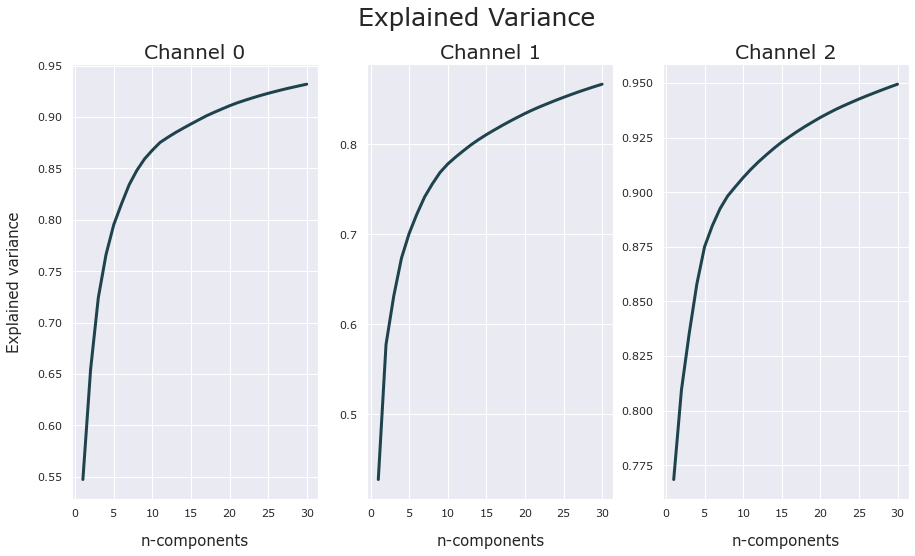

In [118]:
####pca####


##the gft array contains the information for three channels -> gft[#channels,#nuclei,(n*n*n)] , n= pixels

def feature_vector(vector_dimension,gft):
    nr_pca=PCA(n_components=vector_dimension,whiten=True)
    if len(gft.shape)==2:
        feature_vec=nr_pca.fit_transform(gft)
        feature_vec_var=np.cumsum(nr_pca.explained_variance_ratio_)
        return np.array([feature_vec,feature_vec_var],dtype=object)
    else:
        feature_vector_list=[]
        for n in range(gft.shape[0]):
            feature_vec=nr_pca.fit_transform(gft[n,:,:])
            feature_vec_var=np.cumsum(nr_pca.explained_variance_ratio_)
            feature_vector_list.append([feature_vec,feature_vec_var])
        return np.array(feature_vector_list,dtype=object)

feature_vec_gft=feature_vector(30,gft)

# Plot variance

def plot_var(feature_vec_gft):
    fig, axes = plt.subplots(1,3,figsize=(15,8),sharey=False)
    sns.set(font='MS Reference Sans Serif',context='notebook')
    fig.suptitle('Explained Variance',fontsize=25)
    for n in range(feature_vec_gft.shape[0]):
            sns.set(font='MS Reference Sans Serif',context='notebook')
            sns.lineplot(ax=axes[n],x=(np.arange(len(feature_vec_gft[n,1])) + 1),y=feature_vec_gft[n,1],legend=False,linewidth=3,color='#1E434C')
            axes[n].set_title(('Channel '+str(n)),fontsize=20)
            axes[0].set_ylabel('Explained variance',fontsize=15,labelpad=15,fontweight=15)
            axes[n].set_xlabel('n-components',fontsize=15,labelpad=15,fontweight=15)
    fig.savefig('pca_expl_var.png')
            

plot_var(feature_vec_gft)



From the generated plots it is visible that each channel has its own optimal numbers of pca explaining the data, we set for the feature vector:

- Channel 0: PCA 1-6
- Channel 1: PCA 1-6
- Channel 2: PCA 1-6


In [ ]:
# generate feature vector table with first six PCA

feature_vector_table=pd.DataFrame([gft[:,1,]])